In [1]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections.abc import Iterable
import time
import math

batchSize = 32 #Batch size of training set

In [2]:
def trainNetwork(model, loss_function, optimizer, numEpochs, dataloader, numOutputs):
    
    #Set model to training mode
    model.train()
    
    for epoch in range(numEpochs):
    
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        
        #Reset model parameters

        # Iterate over the DataLoader for training data
        for i, data in enumerate(dataloader, 0):

            # Get and prepare input

            preProcessedInputs = data[:, 0:4] #This line doesn't really do anything, delete later?
            targets = data[:, 4:(4+numOutputs)]

            #Process intensity by putting it on a log scale
            intens = data[:, 0:1]
            intens = np.log(intens)
            inputs = torch.cat((intens, data[:,1:4]), axis = 1)

            #Process targets by putting them on a log scale
            targets = np.log(targets)

            #print(type(inputs))

            #Comment the next two lines out if not using GPU
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')

            #Normalize inputs
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], numOutputs))

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            inputs = inputs
            outputs = model(inputs)

            #The following two lines are for debugging only
    #         if i % 10 == 0:
    #             print("Targets:", targets[0:2])
    #             print("Outputs:", outputs[0:2])
    #             print()
    #             print()

            # Compute loss
            loss = loss_function(outputs, targets)

            # Perform backwards propagation
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 10 == 0:
                print('Loss after mini-batch %5d: %.3f' %
                     (i + 1, current_loss / 500))
                current_loss = 0.0

    # Process is complete.
    print('Training process has finished.\n')

In [3]:
def calc_MSE_Error(target, output, index):
    
    targetNP = np.exp(target[:, index].cpu().detach().numpy())
    outputNP = np.exp(output[:, index].cpu().detach().numpy())
    
#     print(targetNP)
#     print(outputNP)
    
    result = np.square(np.subtract(targetNP, outputNP)).mean()
    
#     print("Index: ", index)
#     print(target)
#     print(output)

    print("Result:", result)
    
    return result

In [4]:
def calc_Avg_Percent_Error(target, output, index):
    
    targetNP = np.exp(target[:, index].cpu().detach().numpy())
    outputNP = np.exp(output[:, index].cpu().detach().numpy())
    
    difference = targetNP - outputNP
    difference = np.abs(difference)
    error = np.divide(difference, outputNP) * 100
    
    result = error.mean()
    
    return result

In [5]:
def getModelError(model, epochList, loss_function, trainDataset, testDataset):
    mseErrorList = []
    avgErrorList = []
    mseTrainList = []
    avgTrainList = []
    timeList = []
    
    #print("Epochs to test:", epochList)
    
    
    for numEpochs in epochList:
        
        #Reset model parameters
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        print("Training with", numEpochs, "epochs.")
        
        #Define optimizer 
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        
        #Create dataloader for training set
        dataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
        
        #Start clock
        startTime = time.time()
        
        #First train the network
        trainNetwork(model, loss_function, optimizer, numEpochs, dataloader, numOutputs = 3)
        
        #End clock
        endTime = time.time()
        timeSpent = endTime - startTime #In seconds
        
        #Next test the network
        model.eval()
        
        #Create dataloader for testing set
        testDataloader = DataLoader(testDataset, batch_size=math.floor(0.1*numPoints), shuffle=True)
        iterDataLoader = iter(testDataloader)
        testData = next(iterDataLoader)
        
        #Process the intens value so it is in a log scale
        intens = testData[:, 0:1]
        logIntens = np.log(intens)

        #Create the final tensor of inputs we will feed into the model
        inputs = torch.cat((logIntens, testData[:,1:4]), axis = 1)
        
        #Create the tensor of our actual values
        target = testData[:, 4:7]
        target = np.log(target)

        #Push our tensors to the GPU
        inputs = inputs.to('cuda')
        target = target.to('cuda')

        inputs, target = inputs.float(), target.float()
        target = target.reshape((target.shape[0], 3))

        #Get the model predictions and apply a log-scale to our actual values
        #(Model predictions already have a log-scale applied to them)
        output = model(inputs)
        target = np.log(testData[:, 4:7])
        
#         print(output)
#         print(target)
#         print('\n')
        
        
        
        #Initialize error lists
        #Index mappings:
        #0 = Max KE
        #1 = Total Energy
        #2 = Average Energy
        error = [0., 0., 0.]
        percentError = [0., 0., 0.]

        
        print("Calculate error for test")
        for index in range(3):
            error[index] = calc_MSE_Error(target, output, index)
            percentError[index] = calc_Avg_Percent_Error(target, output, index)
            
        #Append error values into our list
        mseErrorList.append(error)
        avgErrorList.append(percentError)
        timeList.append(timeSpent)
        
        #Also retrieve the testing error
        
        dataloader = DataLoader(trainDataset, batch_size=math.floor(0.1 * numPoints), shuffle=True)
        iterDataLoader = iter(dataloader)
        trainData = next(iterDataLoader)
        
        #Process the intens value so it is in a log scale
        intens = trainData[:, 0:1]
        logIntens = np.log(intens)

        #Create the final tensor of inputs we will feed into the model
        inputs = torch.cat((logIntens, trainData[:,1:4]), axis = 1)
        
        #Create the tensor of our actual values
        target = trainData[:, 4:7]
        target = np.log(target)

        #Push our tensors to the GPU
        inputs = inputs.to('cuda')
        target = target.to('cuda')

        inputs, target = inputs.float(), target.float()
        target = target.reshape((target.shape[0], 3))

        #Get the model predictions and apply a log-scale to our actual values
        #(Model predictions already have a log-scale applied to them)
        trainOutput = model(inputs)
        trainTarget = np.log(trainData[:, 4:7])
        
#         print(output)
#         print(target)


        print("Calculate error for train")
    
        trainError = [0., 0., 0.]
        trainPercentError = [0., 0., 0.]
        
        for index in range(3):
            trainError[index] = calc_MSE_Error(trainTarget, trainOutput, index)
            trainPercentError[index] = calc_Avg_Percent_Error(trainTarget, trainOutput, index)
            
        #Append error values
        mseTrainList.append(trainError)
        avgTrainList.append(trainPercentError)
        
    return mseErrorList, avgErrorList, mseTrainList, avgTrainList, timeList

# Define our neural networks

In [6]:
#Neural network with 2 hidden layers

class MultiRegressor2Layers(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(4)
    self.linear1 = nn.Linear(in_features=4, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.dropout = nn.Dropout()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    #self.dropout = nn.Dropout()
    self.act2 = nn.LeakyReLU()
    self.linear3 = nn.Linear(in_features=16, out_features=8)
    self.act3 = nn.LeakyReLU()
    #self.dropout = nn.Dropout()
    self.output = nn.Linear(in_features=8, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    #x = self.dropout(x)
    x = self.linear2(x)
    x = self.norm2(x)
    #x = self.dropout(x)
    x = self.act2(x)
    x = self.linear3(x)
    x = self.act3(x)
    #x = self.dropout(x)
    x = self.output(x)
    
    
    return x

In [7]:
#Neural network with 1 hidden layer

class MultiRegressor1Layer(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.norm0 = nn.BatchNorm1d(4)
    self.linear1 = nn.Linear(in_features=4, out_features=64)
    self.norm1 = nn.BatchNorm1d(64)
    self.act1 = nn.LeakyReLU()
    self.dropout = nn.Dropout()
    self.linear2 = nn.Linear(in_features=64, out_features=16)
    self.norm2 = nn.BatchNorm1d(16)
    #self.dropout = nn.Dropout()
    self.act2 = nn.LeakyReLU()
    self.output = nn.Linear(in_features=16, out_features = 3)
    


  def forward(self, x):
    '''
      Forward pass
    '''
    x = self.norm0(x)
    x = self.linear1(x)
    x = self.norm1(x)
    x = self.act1(x)
    #x = self.dropout(x)
    x = self.linear2(x)
    x = self.norm2(x)
    #x = self.dropout(x)
    x = self.act2(x)
    x = self.output(x)
    
    
    return x

# Read in the data

In [8]:
numPoints = 100000
#numPoints = 500

#filename = 'Data_Fuchs_v_2.2_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'
filename = 'Data_Fuchs_v_2.2_Wright_Pat_Narrow_Range_lambda_um_0.8_points_' + str(numPoints) + '_seed_0.h5'

h5File = h5py.File(filename, 'r+')

In [9]:
#Read columns

intens = h5File['Intensity_(W_cm2)']
duration = h5File['Pulse_Duration_(fs)']
thickness = h5File['Target_Thickness (um)']
spotSize = h5File['Spot_Size_(FWHM um)']
maxEnergy = h5File['Max_Proton_Energy_(MeV)']
totalEnergy = h5File['Total_Proton_Energy_(MeV)']
avgEnergy = h5File['Avg_Proton_Energy_(MeV)']


#Convert columns into numpy arrays
npIntens = np.fromiter(intens, float)
npDuration = np.fromiter(duration, float)
npThickness = np.fromiter(thickness, float)
npSpot = np.fromiter(spotSize, float)
npMaxEnergy = np.fromiter(maxEnergy, float)
npTotalEnergy = np.fromiter(totalEnergy, float)
npAvgEnergy = np.fromiter(avgEnergy, float)


#Join all of those arrays into one big numpy array
npFile = np.dstack((npIntens, npDuration, npThickness, npSpot, npMaxEnergy, npTotalEnergy, npAvgEnergy))

npFile = npFile.reshape(numPoints, 7)

npTrain = npFile[:math.floor(.9*numPoints), 0:7]
npTest = npFile[math.floor(.9*numPoints):, 0:7]

print(npFile.shape)

(100000, 7)


# Prepare our dataset

In [10]:
training_dataset = h5File.create_dataset(name=None, data=npTrain)
test_dataset = h5File.create_dataset(name=None, data=npTest)

In [11]:
#Choose our loss function

loss_function = nn.MSELoss()

In [12]:
#List which epochs we should test

#epochList = [1]
#epochList = [1, 2, 3]
#epochList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100, 150, 200, 250]
#epochList = [1, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200]
epochList = [1, 5, 10, 15, 20, 50]

In [13]:
#Initialize neural network and dataloader
model1Layer = MultiRegressor1Layer().to('cuda')

model1LayerMSE, model1LayerPercentError, trainMSE, trainPercent, timeList = getModelError(model1Layer, epochList, loss_function, training_dataset, test_dataset)

# print(model1LayerMSE)
# print(trainMSE)

Training with 1 epochs.
Starting epoch 1
Loss after mini-batch     1: 0.222
Loss after mini-batch    11: 2.209
Loss after mini-batch    21: 2.001
Loss after mini-batch    31: 1.630
Loss after mini-batch    41: 1.308
Loss after mini-batch    51: 0.921
Loss after mini-batch    61: 0.630
Loss after mini-batch    71: 0.336
Loss after mini-batch    81: 0.150
Loss after mini-batch    91: 0.040
Loss after mini-batch   101: 0.013
Loss after mini-batch   111: 0.010
Loss after mini-batch   121: 0.008
Loss after mini-batch   131: 0.008
Loss after mini-batch   141: 0.010
Loss after mini-batch   151: 0.008
Loss after mini-batch   161: 0.005
Loss after mini-batch   171: 0.004
Loss after mini-batch   181: 0.005
Loss after mini-batch   191: 0.005
Loss after mini-batch   201: 0.007
Loss after mini-batch   211: 0.006
Loss after mini-batch   221: 0.007
Loss after mini-batch   231: 0.006
Loss after mini-batch   241: 0.005
Loss after mini-batch   251: 0.007
Loss after mini-batch   261: 0.003
Loss after min

Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.002
Loss after mini-batch  2361: 0.003
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.004
Loss after mini-batch  2391: 0.004
Loss after mini-batch  2401: 0.003
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.004
Loss after mini-batch  2431: 0.003
Loss after mini-batch  2441: 0.003
Loss after mini-batch  2451: 0.003
Loss after mini-batch  2461: 0.002
Loss after mini-batch  2471: 0.002
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.003
Loss after mini-batch  2501: 0.002
Loss after mini-batch  2511: 0.003
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.002
Loss after mini-batch  2551: 0.003
Loss after mini-batch  2561: 0.003
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.003
Loss after mini-batch  2601: 0.002
Loss after mini-batc

Loss after mini-batch  1781: 0.003
Loss after mini-batch  1791: 0.004
Loss after mini-batch  1801: 0.004
Loss after mini-batch  1811: 0.002
Loss after mini-batch  1821: 0.002
Loss after mini-batch  1831: 0.003
Loss after mini-batch  1841: 0.002
Loss after mini-batch  1851: 0.002
Loss after mini-batch  1861: 0.003
Loss after mini-batch  1871: 0.002
Loss after mini-batch  1881: 0.003
Loss after mini-batch  1891: 0.004
Loss after mini-batch  1901: 0.003
Loss after mini-batch  1911: 0.003
Loss after mini-batch  1921: 0.003
Loss after mini-batch  1931: 0.003
Loss after mini-batch  1941: 0.002
Loss after mini-batch  1951: 0.003
Loss after mini-batch  1961: 0.003
Loss after mini-batch  1971: 0.002
Loss after mini-batch  1981: 0.002
Loss after mini-batch  1991: 0.002
Loss after mini-batch  2001: 0.003
Loss after mini-batch  2011: 0.004
Loss after mini-batch  2021: 0.003
Loss after mini-batch  2031: 0.002
Loss after mini-batch  2041: 0.004
Loss after mini-batch  2051: 0.003
Loss after mini-batc

Loss after mini-batch  1301: 0.004
Loss after mini-batch  1311: 0.004
Loss after mini-batch  1321: 0.006
Loss after mini-batch  1331: 0.004
Loss after mini-batch  1341: 0.002
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.002
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.002
Loss after mini-batch  1411: 0.002
Loss after mini-batch  1421: 0.002
Loss after mini-batch  1431: 0.003
Loss after mini-batch  1441: 0.003
Loss after mini-batch  1451: 0.002
Loss after mini-batch  1461: 0.003
Loss after mini-batch  1471: 0.002
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.002
Loss after mini-batch  1511: 0.002
Loss after mini-batch  1521: 0.003
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.002
Loss after mini-batch  1551: 0.002
Loss after mini-batch  1561: 0.003
Loss after mini-batch  1571: 0.002
Loss after mini-batc

Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.003
Loss after mini-batch   881: 0.003
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.004
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.002
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.002
Loss after mini-batc

Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.003
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batc

Loss after mini-batch  2681: 0.002
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.002
Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.002
Loss after mini-batch  2751: 0.002
Loss after mini-batch  2761: 0.003
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.002
Loss after mini-batch  2811: 0.001
Starting epoch 5
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Los

Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.002
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.002
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.002
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.002
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batc

Loss after mini-batch  1641: 0.003
Loss after mini-batch  1651: 0.005
Loss after mini-batch  1661: 0.003
Loss after mini-batch  1671: 0.004
Loss after mini-batch  1681: 0.004
Loss after mini-batch  1691: 0.002
Loss after mini-batch  1701: 0.002
Loss after mini-batch  1711: 0.002
Loss after mini-batch  1721: 0.002
Loss after mini-batch  1731: 0.002
Loss after mini-batch  1741: 0.003
Loss after mini-batch  1751: 0.002
Loss after mini-batch  1761: 0.001
Loss after mini-batch  1771: 0.002
Loss after mini-batch  1781: 0.004
Loss after mini-batch  1791: 0.004
Loss after mini-batch  1801: 0.003
Loss after mini-batch  1811: 0.002
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.003
Loss after mini-batch  1841: 0.003
Loss after mini-batch  1851: 0.002
Loss after mini-batch  1861: 0.002
Loss after mini-batch  1871: 0.002
Loss after mini-batch  1881: 0.004
Loss after mini-batch  1891: 0.003
Loss after mini-batch  1901: 0.002
Loss after mini-batch  1911: 0.002
Loss after mini-batc

Loss after mini-batch  1161: 0.003
Loss after mini-batch  1171: 0.002
Loss after mini-batch  1181: 0.002
Loss after mini-batch  1191: 0.003
Loss after mini-batch  1201: 0.003
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.004
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.002
Loss after mini-batch  1261: 0.002
Loss after mini-batch  1271: 0.001
Loss after mini-batch  1281: 0.002
Loss after mini-batch  1291: 0.002
Loss after mini-batch  1301: 0.003
Loss after mini-batch  1311: 0.003
Loss after mini-batch  1321: 0.002
Loss after mini-batch  1331: 0.002
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.002
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.002
Loss after mini-batch  1381: 0.002
Loss after mini-batch  1391: 0.003
Loss after mini-batch  1401: 0.003
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batc

Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.003
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.003
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.002
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.002
Loss after mini-batch   921: 0.002
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batc

Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.003
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.003
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batc

Loss after mini-batch  2551: 0.003
Loss after mini-batch  2561: 0.003
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.002
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.002
Loss after mini-batch  2691: 0.002
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.002
Loss after mini-batch  2721: 0.002
Loss after mini-batch  2731: 0.002
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.002
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.002
Loss after mini-batch  2801: 0.003
Loss after mini-batch  2811: 0.001
Starting epoch 5
Loss after mini-batch     1: 0.000
Los

Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.002
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.002
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.002
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.000
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batc

Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.000
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.000
Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.001
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.001
Loss after mini-batch  1771: 0.003
Loss after mini-batch  1781: 0.002
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.001
Loss after mini-batch  1811: 0.001
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.002
Loss after mini-batch  1841: 0.000
Loss after mini-batch  1851: 0.001
Loss after mini-batch  1861: 0.001
Loss after mini-batch  1871: 0.000
Loss after mini-batc

Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.002
Loss after mini-batch  1141: 0.002
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.002
Loss after mini-batch  1181: 0.002
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.000
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.002
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.001
Loss after mini-batch  1271: 0.001
Loss after mini-batch  1281: 0.001
Loss after mini-batch  1291: 0.001
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.001
Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.000
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.000
Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batc

Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.000
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batc

Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.003
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.000
Loss after mini-batch   411: 0.000
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batc

Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.000
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.000
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.001
Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.001
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.002
Loss after mini-batch  2781: 0.002
Loss after mini-batch  2791: 0.002
Loss after mini-batch  2801: 0.001
Loss after mini-batc

Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.000
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.000
Loss after mini-batch  2121: 0.000
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.002
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batc

Loss after mini-batch  1491: 0.003
Loss after mini-batch  1501: 0.004
Loss after mini-batch  1511: 0.003
Loss after mini-batch  1521: 0.002
Loss after mini-batch  1531: 0.003
Loss after mini-batch  1541: 0.004
Loss after mini-batch  1551: 0.002
Loss after mini-batch  1561: 0.002
Loss after mini-batch  1571: 0.002
Loss after mini-batch  1581: 0.003
Loss after mini-batch  1591: 0.003
Loss after mini-batch  1601: 0.004
Loss after mini-batch  1611: 0.002
Loss after mini-batch  1621: 0.004
Loss after mini-batch  1631: 0.004
Loss after mini-batch  1641: 0.002
Loss after mini-batch  1651: 0.004
Loss after mini-batch  1661: 0.002
Loss after mini-batch  1671: 0.002
Loss after mini-batch  1681: 0.003
Loss after mini-batch  1691: 0.005
Loss after mini-batch  1701: 0.003
Loss after mini-batch  1711: 0.004
Loss after mini-batch  1721: 0.003
Loss after mini-batch  1731: 0.003
Loss after mini-batch  1741: 0.003
Loss after mini-batch  1751: 0.002
Loss after mini-batch  1761: 0.001
Loss after mini-batc

Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.003
Loss after mini-batch  1051: 0.003
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.003
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.002
Loss after mini-batch  1121: 0.002
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.002
Loss after mini-batch  1161: 0.002
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.002
Loss after mini-batch  1201: 0.002
Loss after mini-batch  1211: 0.002
Loss after mini-batch  1221: 0.004
Loss after mini-batch  1231: 0.002
Loss after mini-batch  1241: 0.003
Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.002
Loss after mini-batch  1271: 0.003
Loss after mini-batch  1281: 0.004
Loss after mini-batc

Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.002
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.003
Loss after mini-batch   581: 0.003
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.004
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.003
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.003
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.002
Loss after mini-batc

Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.003
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.003
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.003
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.003
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batc

Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.002
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.002
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.000
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.002
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batc

Loss after mini-batch  1931: 0.002
Loss after mini-batch  1941: 0.000
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.002
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.004
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.002
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.002
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batc

Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.000
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.002
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.000
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.002
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.002
Loss after mini-batch  1681: 0.003
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.002
Loss after mini-batch  1721: 0.000
Loss after mini-batc

Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.000
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batc

Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.000
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.003
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.000
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.003
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.000
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.002
Loss after mini-batc

Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.000
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batc

Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.000
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.000
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.000
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.002
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.002
Loss after mini-batc

Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.002
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.000
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.000
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.001
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.003
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.000
Loss after mini-batc

Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.002
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.002
Loss after mini-batch  1471: 0.002
Loss after mini-batch  1481: 0.002
Loss after mini-batch  1491: 0.002
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.000
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.000
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batc

Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.000
Loss after mini-batch  1001: 0.000
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.003
Loss after mini-batch  1101: 0.003
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.003
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.000
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.001
Loss after mini-batc

Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.000
Loss after mini-batch   501: 0.000
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.000
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.000
Loss after mini-batc

Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batc

Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.000
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.000
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.000
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.000
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batc

Loss after mini-batch  1881: 0.001
Loss after mini-batch  1891: 0.002
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.000
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.000
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.002
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.001
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.000
Loss after mini-batc

Loss after mini-batch  1331: 0.002
Loss after mini-batch  1341: 0.002
Loss after mini-batch  1351: 0.003
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.005
Loss after mini-batch  1381: 0.003
Loss after mini-batch  1391: 0.004
Loss after mini-batch  1401: 0.004
Loss after mini-batch  1411: 0.004
Loss after mini-batch  1421: 0.004
Loss after mini-batch  1431: 0.003
Loss after mini-batch  1441: 0.003
Loss after mini-batch  1451: 0.003
Loss after mini-batch  1461: 0.004
Loss after mini-batch  1471: 0.003
Loss after mini-batch  1481: 0.003
Loss after mini-batch  1491: 0.003
Loss after mini-batch  1501: 0.003
Loss after mini-batch  1511: 0.005
Loss after mini-batch  1521: 0.005
Loss after mini-batch  1531: 0.003
Loss after mini-batch  1541: 0.003
Loss after mini-batch  1551: 0.004
Loss after mini-batch  1561: 0.002
Loss after mini-batch  1571: 0.002
Loss after mini-batch  1581: 0.003
Loss after mini-batch  1591: 0.003
Loss after mini-batch  1601: 0.003
Loss after mini-batc

Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.003
Loss after mini-batch   931: 0.003
Loss after mini-batch   941: 0.003
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.002
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.002
Loss after mini-batch   991: 0.003
Loss after mini-batch  1001: 0.002
Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.002
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.002
Loss after mini-batch  1071: 0.002
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.003
Loss after mini-batch  1121: 0.003
Loss after mini-batc

Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.002
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.003
Loss after mini-batch   461: 0.003
Loss after mini-batch   471: 0.004
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.004
Loss after mini-batch   501: 0.002
Loss after mini-batch   511: 0.002
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.002
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.003
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.002
Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batc

Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.001
Loss after mini-batch  2761: 0.003
Loss after mini-batch  2771: 0.002
Loss after mini-batch  2781: 0.002
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.003
Loss after mini-batch  2811: 0.002
Starting epoch 4
Loss after mini-batch     1: 0.001
Loss after mini-batch    11: 0.003
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.003
Loss after mini-batch   181: 0.003
Loss after mini-batch   191: 0.001
Los

Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.002
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.002
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.002
Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.003
Loss after mini-batch  2441: 0.002
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.002
Loss after mini-batch  2531: 0.002
Loss after mini-batc

Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.002
Loss after mini-batch  1801: 0.001
Loss after mini-batch  1811: 0.001
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.001
Loss after mini-batch  1841: 0.001
Loss after mini-batch  1851: 0.002
Loss after mini-batch  1861: 0.002
Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.002
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batc

Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.001
Loss after mini-batch  1321: 0.002
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.002
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.001
Loss after mini-batch  1411: 0.000
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.002
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.002
Loss after mini-batc

Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.002
Loss after mini-batch   951: 0.002
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.002
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.002
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.001
Loss after mini-batc

Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.002
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batc

Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.001
Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.001
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.002
Loss after mini-batch  2801: 0.001
Loss after mini-batch  2811: 0.001
Starting epoch 9
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.000
Los

Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.002
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.000
Loss after mini-batch  2261: 0.000
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.002
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.002
Loss after mini-batch  2411: 0.002
Loss after mini-batch  2421: 0.002
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batc

Loss after mini-batch  1731: 0.001
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.000
Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.001
Loss after mini-batch  1811: 0.000
Loss after mini-batch  1821: 0.000
Loss after mini-batch  1831: 0.000
Loss after mini-batch  1841: 0.000
Loss after mini-batch  1851: 0.001
Loss after mini-batch  1861: 0.001
Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.000
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.002
Loss after mini-batch  2001: 0.002
Loss after mini-batc

Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.001
Loss after mini-batch  1271: 0.001
Loss after mini-batch  1281: 0.001
Loss after mini-batch  1291: 0.001
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.000
Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.001
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batc

Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.003
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.002
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.002
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.000
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.000
Loss after mini-batc

Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.000
Loss after mini-batc

Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.000
Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.001
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.001
Loss after mini-batch  2811: 0.001
Starting epoch 14
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Lo

Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.002
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.002
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.000
Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.002
Loss after mini-batch  2391: 0.002
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.002
Loss after mini-batch  2421: 0.002
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batc

Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.001
Loss after mini-batch  1741: 0.002
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.001
Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.000
Loss after mini-batch  1811: 0.001
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.002
Loss after mini-batch  1841: 0.001
Loss after mini-batch  1851: 0.001
Loss after mini-batch  1861: 0.000
Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.000
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.002
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.000
Loss after mini-batch  1981: 0.001
Loss after mini-batc

Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.001
Loss after mini-batch  1271: 0.000
Loss after mini-batch  1281: 0.001
Loss after mini-batch  1291: 0.001
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.001
Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.002
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.002
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batc

Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.000
Loss after mini-batc

Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.000
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.001
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.002
Loss after mini-batch   451: 0.001
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.000
Loss after mini-batch   531: 0.000
Loss after mini-batch   541: 0.000
Loss after mini-batc

Loss after mini-batch  2621: 0.000
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.001
Loss after mini-batch  2731: 0.000
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.002
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.001
Loss after mini-batch  2811: 0.001
Starting epoch 19
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Lo

Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.000
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.002
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.000
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.000
Loss after mini-batc

Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.001
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.000
Loss after mini-batch  1761: 0.001
Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.001
Loss after mini-batch  1811: 0.000
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.002
Loss after mini-batch  1841: 0.001
Loss after mini-batch  1851: 0.001
Loss after mini-batch  1861: 0.000
Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.001
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.002
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batc

Loss after mini-batch  1111: 0.003
Loss after mini-batch  1121: 0.005
Loss after mini-batch  1131: 0.005
Loss after mini-batch  1141: 0.003
Loss after mini-batch  1151: 0.004
Loss after mini-batch  1161: 0.005
Loss after mini-batch  1171: 0.003
Loss after mini-batch  1181: 0.004
Loss after mini-batch  1191: 0.003
Loss after mini-batch  1201: 0.004
Loss after mini-batch  1211: 0.003
Loss after mini-batch  1221: 0.003
Loss after mini-batch  1231: 0.003
Loss after mini-batch  1241: 0.003
Loss after mini-batch  1251: 0.003
Loss after mini-batch  1261: 0.002
Loss after mini-batch  1271: 0.002
Loss after mini-batch  1281: 0.004
Loss after mini-batch  1291: 0.002
Loss after mini-batch  1301: 0.004
Loss after mini-batch  1311: 0.003
Loss after mini-batch  1321: 0.006
Loss after mini-batch  1331: 0.003
Loss after mini-batch  1341: 0.003
Loss after mini-batch  1351: 0.002
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.003
Loss after mini-batch  1381: 0.004
Loss after mini-batc

Loss after mini-batch   631: 0.003
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.003
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.003
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.004
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.003
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.003
Loss after mini-batch   831: 0.003
Loss after mini-batch   841: 0.001
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.003
Loss after mini-batch   871: 0.002
Loss after mini-batch   881: 0.002
Loss after mini-batch   891: 0.003
Loss after mini-batch   901: 0.002
Loss after mini-batc

Loss after mini-batch   151: 0.004
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.003
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.003
Loss after mini-batch   281: 0.003
Loss after mini-batch   291: 0.003
Loss after mini-batch   301: 0.003
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.002
Loss after mini-batch   421: 0.002
Loss after mini-batc

Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.002
Loss after mini-batch  2531: 0.002
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.002
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.002
Loss after mini-batch  2611: 0.002
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.002
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.002
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.002
Loss after mini-batch  2691: 0.002
Loss after mini-batch  2701: 0.002
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.002
Loss after mini-batch  2731: 0.002
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.002
Loss after mini-batch  2761: 0.002
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batc

Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.002
Loss after mini-batch  2071: 0.002
Loss after mini-batch  2081: 0.002
Loss after mini-batch  2091: 0.003
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.002
Loss after mini-batch  2121: 0.002
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.002
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.002
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.002
Loss after mini-batch  2241: 0.002
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batc

Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.002
Loss after mini-batch  1671: 0.002
Loss after mini-batch  1681: 0.002
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.002
Loss after mini-batch  1711: 0.000
Loss after mini-batch  1721: 0.000
Loss after mini-batch  1731: 0.002
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.002
Loss after mini-batch  1761: 0.001
Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.001
Loss after mini-batch  1811: 0.001
Loss after mini-batch  1821: 0.001
Loss after mini-batc

Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.004
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.002
Loss after mini-batch  1151: 0.002
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.002
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.000
Loss after mini-batch  1251: 0.002
Loss after mini-batch  1261: 0.002
Loss after mini-batch  1271: 0.003
Loss after mini-batch  1281: 0.003
Loss after mini-batch  1291: 0.002
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.001
Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.001
Loss after mini-batc

Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.000
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.000
Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batc

Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.001
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.001
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batc

Loss after mini-batch  2481: 0.002
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.002
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.000
Loss after mini-batch  2581: 0.002
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.002
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.000
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.001
Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.002
Loss after mini-batch  2751: 0.001
Loss after mini-batc

Loss after mini-batch  2001: 0.000
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.002
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.000
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.002
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.002
Loss after mini-batch  2241: 0.002
Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.001
Loss after mini-batc

Loss after mini-batch  1521: 0.000
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.000
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.000
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.002
Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batc

Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.002
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.000
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.002
Loss after mini-batch  1191: 0.000
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.001
Loss after mini-batch  1271: 0.001
Loss after mini-batch  1281: 0.001
Loss after mini-batch  1291: 0.001
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.001
Loss after mini-batch  1321: 0.001
Loss after mini-batc

Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.001
Loss after mini-batch   831: 0.001
Loss after mini-batch   841: 0.001
Loss after mini-batc

Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.000
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.000
Loss after mini-batch   341: 0.000
Loss after mini-batch   351: 0.000
Loss after mini-batch   361: 0.000
Loss after mini-batc

Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.000
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batch  2721: 0.001
Loss after mini-batc

Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.000
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.000
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.002
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batch  2241: 0.001
Loss after mini-batch  2251: 0.001
Loss after mini-batc

Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.000
Loss after mini-batch  1551: 0.000
Loss after mini-batch  1561: 0.000
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.000
Loss after mini-batch  1691: 0.001
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.001
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.002
Loss after mini-batch  1771: 0.002
Loss after mini-batch  1781: 0.001
Loss after mini-batc

Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.001
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.001
Loss after mini-batch  1261: 0.000
Loss after mini-batch  1271: 0.000
Loss after mini-batch  1281: 0.001
Loss after mini-batch  1291: 0.001
Loss after mini-batch  1301: 0.001
Loss after mini-batc

Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.002
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.003
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.000
Loss after mini-batch   761: 0.000
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batch   811: 0.001
Loss after mini-batch   821: 0.000
Loss after mini-batc

Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.000
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.001
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batch   331: 0.001
Loss after mini-batch   341: 0.001
Loss after mini-batch   351: 0.001
Loss after mini-batc

Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.000
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.000
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.000
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.001
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batch  2691: 0.001
Loss after mini-batch  2701: 0.001
Loss after mini-batch  2711: 0.001
Loss after mini-batc

Loss after mini-batch  1961: 0.000
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.000
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.000
Loss after mini-batch  2061: 0.000
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.001
Loss after mini-batch  2101: 0.000
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.000
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batch  2211: 0.001
Loss after mini-batch  2221: 0.001
Loss after mini-batch  2231: 0.001
Loss after mini-batc

Loss after mini-batch  1491: 0.002
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.000
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.000
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batch  1691: 0.002
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.002
Loss after mini-batch  1721: 0.001
Loss after mini-batch  1731: 0.000
Loss after mini-batch  1741: 0.001
Loss after mini-batch  1751: 0.001
Loss after mini-batch  1761: 0.001
Loss after mini-batc

Loss after mini-batch  1011: 0.002
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.000
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.000
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.000
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.000
Loss after mini-batch  1211: 0.000
Loss after mini-batch  1221: 0.000
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batch  1251: 0.000
Loss after mini-batch  1261: 0.001
Loss after mini-batch  1271: 0.001
Loss after mini-batch  1281: 0.001
Loss after mini-batc

Loss after mini-batch   531: 0.000
Loss after mini-batch   541: 0.000
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.000
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.001
Loss after mini-batch   761: 0.001
Loss after mini-batch   771: 0.001
Loss after mini-batch   781: 0.001
Loss after mini-batch   791: 0.001
Loss after mini-batch   801: 0.001
Loss after mini-batc

Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.000
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.000
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.000
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.001
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.001
Loss after mini-batch   311: 0.001
Loss after mini-batch   321: 0.001
Loss after mini-batc

Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.000
Loss after mini-batch  2481: 0.000
Loss after mini-batch  2491: 0.000
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.000
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batch  2561: 0.000
Loss after mini-batch  2571: 0.000
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.001
Loss after mini-batch  2641: 0.001
Loss after mini-batch  2651: 0.002
Loss after mini-batch  2661: 0.001
Loss after mini-batch  2671: 0.001
Loss after mini-batch  2681: 0.001
Loss after mini-batc

Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.002
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.000
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.000
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.000
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.000
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.002
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.000
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batch  2161: 0.001
Loss after mini-batch  2171: 0.001
Loss after mini-batch  2181: 0.001
Loss after mini-batch  2191: 0.001
Loss after mini-batch  2201: 0.001
Loss after mini-batc

Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.000
Loss after mini-batch  1491: 0.000
Loss after mini-batch  1501: 0.000
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.000
Loss after mini-batch  1581: 0.000
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.000
Loss after mini-batch  1611: 0.000
Loss after mini-batch  1621: 0.000
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.002
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.001
Loss after mini-batch  1691: 0.000
Loss after mini-batch  1701: 0.001
Loss after mini-batch  1711: 0.001
Loss after mini-batch  1721: 0.001
Loss after mini-batc

Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.002
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.000
Loss after mini-batch  1131: 0.000
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.000
Loss after mini-batch  1191: 0.000
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.000
Loss after mini-batch  1221: 0.001
Loss after mini-batch  1231: 0.001
Loss after mini-batch  1241: 0.001
Loss after mini-batc

Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.000
Loss after mini-batch   511: 0.000
Loss after mini-batch   521: 0.000
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.002
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.000
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.000
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.001
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.001
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.001
Loss after mini-batc

Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.000
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.000
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.001
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.000
Loss after mini-batc

Loss after mini-batch  2361: 0.000
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.000
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.000
Loss after mini-batch  2421: 0.000
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.002
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.000
Loss after mini-batch  2501: 0.000
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.002
Loss after mini-batch  2541: 0.000
Loss after mini-batch  2551: 0.000
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.000
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.001
Loss after mini-batch  2611: 0.001
Loss after mini-batch  2621: 0.001
Loss after mini-batch  2631: 0.000
Loss after mini-batc

Loss after mini-batch  1881: 0.001
Loss after mini-batch  1891: 0.000
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.000
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.002
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.000
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.000
Loss after mini-batch  2091: 0.001
Loss after mini-batch  2101: 0.001
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.001
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batch  2151: 0.001
Loss after mini-batc

Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.000
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.000
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.002
Loss after mini-batch  1481: 0.000
Loss after mini-batch  1491: 0.000
Loss after mini-batch  1501: 0.000
Loss after mini-batch  1511: 0.000
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.000
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.001
Loss after mini-batch  1641: 0.001
Loss after mini-batch  1651: 0.001
Loss after mini-batch  1661: 0.001
Loss after mini-batch  1671: 0.001
Loss after mini-batch  1681: 0.000
Loss after mini-batc

Loss after mini-batch   941: 0.000
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.002
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.001
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.000
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.000
Loss after mini-batch  1071: 0.000
Loss after mini-batch  1081: 0.000
Loss after mini-batch  1091: 0.000
Loss after mini-batch  1101: 0.000
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.000
Loss after mini-batch  1141: 0.000
Loss after mini-batch  1151: 0.000
Loss after mini-batch  1161: 0.001
Loss after mini-batch  1171: 0.000
Loss after mini-batch  1181: 0.001
Loss after mini-batch  1191: 0.001
Loss after mini-batch  1201: 0.001
Loss after mini-batch  1211: 0.000
Loss after mini-batc

Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.002
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.000
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.001
Loss after mini-batch   701: 0.001
Loss after mini-batch   711: 0.001
Loss after mini-batch   721: 0.000
Loss after mini-batch   731: 0.001
Loss after mini-batch   741: 0.000
Loss after mini-batc

Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.000
Loss after mini-batch    31: 0.000
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.001
Loss after mini-batch   241: 0.001
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.001
Loss after mini-batch   271: 0.001
Loss after mini-batc

Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.000
Loss after mini-batch  2401: 0.000
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.000
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.000
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.001
Loss after mini-batch  2531: 0.000
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.000
Loss after mini-batch  2561: 0.000
Loss after mini-batch  2571: 0.001
Loss after mini-batch  2581: 0.001
Loss after mini-batch  2591: 0.001
Loss after mini-batch  2601: 0.002
Loss after mini-batch  2611: 0.000
Loss after mini-batch  2621: 0.001
Loss after mini-batc

Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.000
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.000
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.000
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.000
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.001
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.000
Loss after mini-batch  2111: 0.001
Loss after mini-batch  2121: 0.000
Loss after mini-batch  2131: 0.001
Loss after mini-batch  2141: 0.001
Loss after mini-batc

Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.001
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.000
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.000
Loss after mini-batch  1561: 0.000
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batch  1601: 0.000
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.001
Loss after mini-batch  1631: 0.000
Loss after mini-batch  1641: 0.000
Loss after mini-batch  1651: 0.000
Loss after mini-batch  1661: 0.001
Loss after mini-batc

Loss after mini-batch   911: 0.000
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.000
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.000
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.000
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.000
Loss after mini-batch  1021: 0.000
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.002
Loss after mini-batch  1131: 0.002
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batch  1161: 0.000
Loss after mini-batch  1171: 0.001
Loss after mini-batch  1181: 0.000
Loss after mini-batc

Loss after mini-batch   431: 0.000
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.001
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.000
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.000
Loss after mini-batch   581: 0.000
Loss after mini-batch   591: 0.000
Loss after mini-batch   601: 0.000
Loss after mini-batch   611: 0.000
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.000
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.000
Loss after mini-batch   681: 0.001
Loss after mini-batch   691: 0.000
Loss after mini-batch   701: 0.001
Loss after mini-batc

Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.000
Loss after mini-batch  2811: 0.001
Starting epoch 38
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.000
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.000
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.001
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.001
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.000
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.000
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Loss after mini-batch   221: 0.001
Loss after mini-batch   231: 0.000
Lo

Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.000
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.000
Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.000
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.000
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.000
Loss after mini-batch  2471: 0.000
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.000
Loss after mini-batch  2521: 0.000
Loss after mini-batch  2531: 0.000
Loss after mini-batch  2541: 0.000
Loss after mini-batch  2551: 0.000
Loss after mini-batch  2561: 0.001
Loss after mini-batch  2571: 0.000
Loss after mini-batch  2581: 0.000
Loss after mini-batc

Loss after mini-batch  1831: 0.001
Loss after mini-batch  1841: 0.000
Loss after mini-batch  1851: 0.001
Loss after mini-batch  1861: 0.001
Loss after mini-batch  1871: 0.000
Loss after mini-batch  1881: 0.001
Loss after mini-batch  1891: 0.000
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.000
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.000
Loss after mini-batch  2001: 0.000
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.000
Loss after mini-batch  2031: 0.001
Loss after mini-batch  2041: 0.000
Loss after mini-batch  2051: 0.000
Loss after mini-batch  2061: 0.000
Loss after mini-batch  2071: 0.001
Loss after mini-batch  2081: 0.000
Loss after mini-batch  2091: 0.000
Loss after mini-batch  2101: 0.000
Loss after mini-batc

Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.000
Loss after mini-batch  1401: 0.000
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.001
Loss after mini-batch  1471: 0.000
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.000
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.000
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.001
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.000
Loss after mini-batch  1601: 0.001
Loss after mini-batch  1611: 0.001
Loss after mini-batch  1621: 0.000
Loss after mini-batch  1631: 0.000
Loss after mini-batc

Loss after mini-batch   881: 0.000
Loss after mini-batch   891: 0.001
Loss after mini-batch   901: 0.000
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.000
Loss after mini-batch   951: 0.001
Loss after mini-batch   961: 0.000
Loss after mini-batch   971: 0.000
Loss after mini-batch   981: 0.000
Loss after mini-batch   991: 0.000
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.001
Loss after mini-batch  1031: 0.000
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.001
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.001
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.001
Loss after mini-batch  1131: 0.001
Loss after mini-batch  1141: 0.001
Loss after mini-batch  1151: 0.001
Loss after mini-batc

Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.000
Loss after mini-batch   431: 0.001
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.001
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.002
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.000
Loss after mini-batch   561: 0.000
Loss after mini-batch   571: 0.001
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.001
Loss after mini-batch   601: 0.000
Loss after mini-batch   611: 0.000
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.000
Loss after mini-batch   641: 0.001
Loss after mini-batch   651: 0.001
Loss after mini-batch   661: 0.001
Loss after mini-batch   671: 0.001
Loss after mini-batc

Loss after mini-batch  2761: 0.000
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.001
Loss after mini-batch  2791: 0.002
Loss after mini-batch  2801: 0.000
Loss after mini-batch  2811: 0.000
Starting epoch 43
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.000
Loss after mini-batch    51: 0.000
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.001
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.001
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.001
Loss after mini-batch   181: 0.001
Loss after mini-batch   191: 0.001
Loss after mini-batch   201: 0.001
Loss after mini-batch   211: 0.001
Lo

Loss after mini-batch  2281: 0.001
Loss after mini-batch  2291: 0.001
Loss after mini-batch  2301: 0.001
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.000
Loss after mini-batch  2361: 0.000
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.001
Loss after mini-batch  2421: 0.000
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.000
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.001
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.001
Loss after mini-batch  2511: 0.001
Loss after mini-batch  2521: 0.000
Loss after mini-batch  2531: 0.001
Loss after mini-batch  2541: 0.001
Loss after mini-batch  2551: 0.001
Loss after mini-batc

Loss after mini-batch  1801: 0.000
Loss after mini-batch  1811: 0.001
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.001
Loss after mini-batch  1841: 0.001
Loss after mini-batch  1851: 0.000
Loss after mini-batch  1861: 0.002
Loss after mini-batch  1871: 0.000
Loss after mini-batch  1881: 0.000
Loss after mini-batch  1891: 0.001
Loss after mini-batch  1901: 0.001
Loss after mini-batch  1911: 0.001
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.000
Loss after mini-batch  1961: 0.000
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.000
Loss after mini-batch  1991: 0.000
Loss after mini-batch  2001: 0.000
Loss after mini-batch  2011: 0.001
Loss after mini-batch  2021: 0.001
Loss after mini-batch  2031: 0.002
Loss after mini-batch  2041: 0.001
Loss after mini-batch  2051: 0.001
Loss after mini-batch  2061: 0.001
Loss after mini-batch  2071: 0.001
Loss after mini-batc

Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.001
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.001
Loss after mini-batch  1381: 0.000
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.001
Loss after mini-batch  1411: 0.001
Loss after mini-batch  1421: 0.001
Loss after mini-batch  1431: 0.000
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.000
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.001
Loss after mini-batch  1491: 0.001
Loss after mini-batch  1501: 0.001
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.000
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.001
Loss after mini-batch  1571: 0.000
Loss after mini-batch  1581: 0.001
Loss after mini-batch  1591: 0.001
Loss after mini-batc

Loss after mini-batch   851: 0.001
Loss after mini-batch   861: 0.001
Loss after mini-batch   871: 0.001
Loss after mini-batch   881: 0.001
Loss after mini-batch   891: 0.000
Loss after mini-batch   901: 0.001
Loss after mini-batch   911: 0.001
Loss after mini-batch   921: 0.001
Loss after mini-batch   931: 0.001
Loss after mini-batch   941: 0.001
Loss after mini-batch   951: 0.000
Loss after mini-batch   961: 0.001
Loss after mini-batch   971: 0.001
Loss after mini-batch   981: 0.001
Loss after mini-batch   991: 0.000
Loss after mini-batch  1001: 0.001
Loss after mini-batch  1011: 0.001
Loss after mini-batch  1021: 0.000
Loss after mini-batch  1031: 0.001
Loss after mini-batch  1041: 0.001
Loss after mini-batch  1051: 0.000
Loss after mini-batch  1061: 0.001
Loss after mini-batch  1071: 0.001
Loss after mini-batch  1081: 0.001
Loss after mini-batch  1091: 0.001
Loss after mini-batch  1101: 0.000
Loss after mini-batch  1111: 0.001
Loss after mini-batch  1121: 0.000
Loss after mini-batc

Loss after mini-batch   371: 0.001
Loss after mini-batch   381: 0.000
Loss after mini-batch   391: 0.001
Loss after mini-batch   401: 0.001
Loss after mini-batch   411: 0.001
Loss after mini-batch   421: 0.001
Loss after mini-batch   431: 0.000
Loss after mini-batch   441: 0.001
Loss after mini-batch   451: 0.000
Loss after mini-batch   461: 0.000
Loss after mini-batch   471: 0.000
Loss after mini-batch   481: 0.001
Loss after mini-batch   491: 0.001
Loss after mini-batch   501: 0.001
Loss after mini-batch   511: 0.001
Loss after mini-batch   521: 0.001
Loss after mini-batch   531: 0.001
Loss after mini-batch   541: 0.001
Loss after mini-batch   551: 0.001
Loss after mini-batch   561: 0.001
Loss after mini-batch   571: 0.000
Loss after mini-batch   581: 0.001
Loss after mini-batch   591: 0.000
Loss after mini-batch   601: 0.001
Loss after mini-batch   611: 0.001
Loss after mini-batch   621: 0.001
Loss after mini-batch   631: 0.001
Loss after mini-batch   641: 0.001
Loss after mini-batc

Loss after mini-batch  2731: 0.001
Loss after mini-batch  2741: 0.001
Loss after mini-batch  2751: 0.001
Loss after mini-batch  2761: 0.001
Loss after mini-batch  2771: 0.001
Loss after mini-batch  2781: 0.002
Loss after mini-batch  2791: 0.001
Loss after mini-batch  2801: 0.000
Loss after mini-batch  2811: 0.001
Starting epoch 48
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.001
Loss after mini-batch    21: 0.001
Loss after mini-batch    31: 0.001
Loss after mini-batch    41: 0.001
Loss after mini-batch    51: 0.001
Loss after mini-batch    61: 0.001
Loss after mini-batch    71: 0.001
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.001
Loss after mini-batch   111: 0.001
Loss after mini-batch   121: 0.001
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.001
Loss after mini-batch   151: 0.000
Loss after mini-batch   161: 0.001
Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.001
Lo

Loss after mini-batch  2251: 0.001
Loss after mini-batch  2261: 0.001
Loss after mini-batch  2271: 0.000
Loss after mini-batch  2281: 0.000
Loss after mini-batch  2291: 0.000
Loss after mini-batch  2301: 0.000
Loss after mini-batch  2311: 0.001
Loss after mini-batch  2321: 0.001
Loss after mini-batch  2331: 0.001
Loss after mini-batch  2341: 0.001
Loss after mini-batch  2351: 0.001
Loss after mini-batch  2361: 0.001
Loss after mini-batch  2371: 0.001
Loss after mini-batch  2381: 0.001
Loss after mini-batch  2391: 0.001
Loss after mini-batch  2401: 0.001
Loss after mini-batch  2411: 0.000
Loss after mini-batch  2421: 0.001
Loss after mini-batch  2431: 0.001
Loss after mini-batch  2441: 0.001
Loss after mini-batch  2451: 0.001
Loss after mini-batch  2461: 0.001
Loss after mini-batch  2471: 0.001
Loss after mini-batch  2481: 0.000
Loss after mini-batch  2491: 0.001
Loss after mini-batch  2501: 0.000
Loss after mini-batch  2511: 0.000
Loss after mini-batch  2521: 0.000
Loss after mini-batc

Loss after mini-batch  1771: 0.001
Loss after mini-batch  1781: 0.001
Loss after mini-batch  1791: 0.001
Loss after mini-batch  1801: 0.000
Loss after mini-batch  1811: 0.000
Loss after mini-batch  1821: 0.001
Loss after mini-batch  1831: 0.001
Loss after mini-batch  1841: 0.000
Loss after mini-batch  1851: 0.000
Loss after mini-batch  1861: 0.000
Loss after mini-batch  1871: 0.001
Loss after mini-batch  1881: 0.000
Loss after mini-batch  1891: 0.000
Loss after mini-batch  1901: 0.000
Loss after mini-batch  1911: 0.000
Loss after mini-batch  1921: 0.001
Loss after mini-batch  1931: 0.001
Loss after mini-batch  1941: 0.001
Loss after mini-batch  1951: 0.001
Loss after mini-batch  1961: 0.001
Loss after mini-batch  1971: 0.001
Loss after mini-batch  1981: 0.001
Loss after mini-batch  1991: 0.001
Loss after mini-batch  2001: 0.001
Loss after mini-batch  2011: 0.000
Loss after mini-batch  2021: 0.002
Loss after mini-batch  2031: 0.002
Loss after mini-batch  2041: 0.001
Loss after mini-batc

Loss after mini-batch  1291: 0.000
Loss after mini-batch  1301: 0.001
Loss after mini-batch  1311: 0.000
Loss after mini-batch  1321: 0.001
Loss after mini-batch  1331: 0.001
Loss after mini-batch  1341: 0.000
Loss after mini-batch  1351: 0.001
Loss after mini-batch  1361: 0.001
Loss after mini-batch  1371: 0.000
Loss after mini-batch  1381: 0.001
Loss after mini-batch  1391: 0.001
Loss after mini-batch  1401: 0.001
Loss after mini-batch  1411: 0.000
Loss after mini-batch  1421: 0.002
Loss after mini-batch  1431: 0.001
Loss after mini-batch  1441: 0.001
Loss after mini-batch  1451: 0.001
Loss after mini-batch  1461: 0.000
Loss after mini-batch  1471: 0.001
Loss after mini-batch  1481: 0.000
Loss after mini-batch  1491: 0.000
Loss after mini-batch  1501: 0.000
Loss after mini-batch  1511: 0.001
Loss after mini-batch  1521: 0.001
Loss after mini-batch  1531: 0.001
Loss after mini-batch  1541: 0.001
Loss after mini-batch  1551: 0.001
Loss after mini-batch  1561: 0.000
Loss after mini-batc

In [14]:
def splitErrorList(errorList):
    maxEnergyError = []
    totalEnergyError = []
    avgEnergyError = []

    for element in errorList:
        maxEnergyError.append(element[0])
        totalEnergyError.append(element[1])
        avgEnergyError.append(element[2])
        
    return maxEnergyError, totalEnergyError, avgEnergyError

In [15]:
print(model1LayerMSE)
print(model1LayerPercentError)
print('\n')
print(trainMSE)
print(trainPercent)

maxEnergyMSE, totalEnergyMSE, avgEnergyMSE = splitErrorList(model1LayerMSE)
maxEnergyPercent, totalEnergyPercent, avgEnergyPercent = splitErrorList(model1LayerPercentError)

trainMaxMSE, trainTotalMSE, trainAvgMSE = splitErrorList(trainMSE)
trainMaxPercent, trainTotalPercent, trainAvgPercent = splitErrorList(trainPercent)

print(trainMaxMSE)
print(maxEnergyMSE)

[[5.6978141831636326e-06, 1.826553267105639e-15, 1.328771315295793e-07], [1.8739067296662588e-05, 2.733749983124259e-15, 2.9702573796996083e-07], [8.479282063237006e-06, 2.7615405287048097e-15, 1.619183970067513e-07], [1.0995086988557976e-05, 9.972341754381332e-16, 1.719939080727756e-07], [2.8987754719841756e-05, 1.737798069415805e-14, 6.226525531170417e-07], [3.811153447359363e-05, 9.125097411374439e-15, 6.473551775648633e-07]]
[[9.003389914677687, 13.435528497275815, 8.41432986321646], [8.229353694367378, 14.313656050329719, 8.255411196914693], [6.871202907559728, 14.982273992363268, 6.968154810180534], [12.829914110043587, 26.607821593869424, 13.389491215689986], [12.290295881148435, 27.775826795091845, 13.318004522922582], [10.244809549320886, 20.453482240665874, 10.028581486654229]]


[[5.751722253465613e-06, 1.780939927964189e-15, 1.3323290120690164e-07], [1.828420918622595e-05, 2.6569664252781055e-15, 2.891211371696739e-07], [8.695034595673081e-06, 2.8894699096341713e-15, 1.6507

# Now plot errors and running time

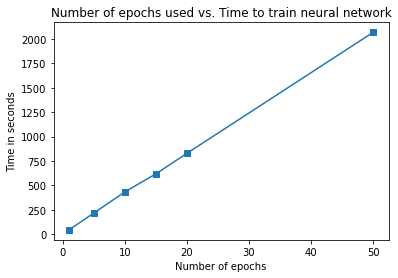

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

#Time spent plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList, timeList, marker='s')
plt.title("Number of epochs used vs. Time to train neural network")
plt.xlabel("Number of epochs")
plt.ylabel("Time in seconds")


#plt.legend(loc='upper left');
plt.show()

In [17]:
for epochElement, timeElement in zip(epochList, timeList):
    
    minuteValue = timeElement / 60
    
    print("Number of epochs:", epochElement)
    print("Time spent:", minuteValue, "minutes", '\n')

Number of epochs: 1
Time spent: 0.7480666995048523 minutes 

Number of epochs: 5
Time spent: 3.6164168039957683 minutes 

Number of epochs: 10
Time spent: 7.232774639129639 minutes 

Number of epochs: 15
Time spent: 10.31501669883728 minutes 

Number of epochs: 20
Time spent: 13.82526669104894 minutes 

Number of epochs: 50
Time spent: 34.48906991481781 minutes 



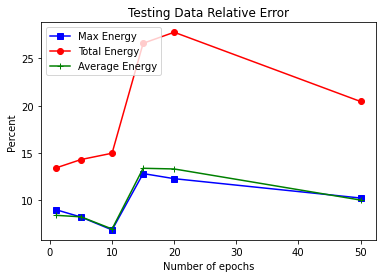

In [18]:
#Percent Error plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)


plt.plot(epochList, maxEnergyPercent, c='b', marker="s", label='Max Energy')
plt.plot(epochList, totalEnergyPercent, c='r', marker="o", label='Total Energy')
plt.plot(epochList, avgEnergyPercent, c='g', marker='+', label='Average Energy')
plt.title("Testing Data Relative Error")
plt.xlabel("Number of epochs")
plt.ylabel("Percent")
plt.legend(loc='upper left');
plt.show()

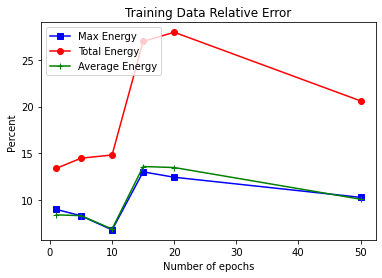

In [19]:
#Percent Error plot for training data
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList, trainMaxPercent, c='b', marker="s", label='Max Energy')
plt.plot(epochList, trainTotalPercent, c='r', marker="o", label='Total Energy')
plt.plot(epochList, trainAvgPercent, c='g', marker='+', label='Average Energy')
plt.title("Training Data Relative Error")
plt.xlabel("Number of epochs")
plt.ylabel("Percent")
plt.legend(loc='upper left');
plt.show()

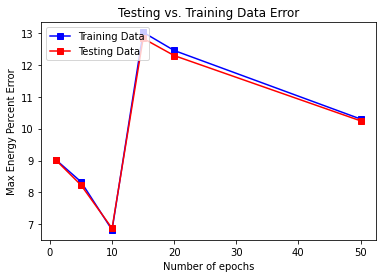

In [20]:
#Compare errors of train and test using just the max energy % error

fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)

plt.plot(epochList, trainMaxPercent, c='b', marker="s", label='Training Data')
plt.plot(epochList, maxEnergyPercent, c='r', marker="s", label='Testing Data')

plt.title("Testing vs. Training Data Error")
plt.xlabel("Number of epochs")
plt.ylabel("Max Energy Percent Error")
plt.legend(loc='upper left')
plt.show()

In [21]:
for epoch, maxError, totalError, avgError in zip(epochList, maxEnergyPercent, totalEnergyPercent, avgEnergyPercent):
    print("Number of epochs:", epoch)
    print("Max energy percent error:", maxError)
    print("Total energy percent error:", totalError)
    print("Average energy percent error:", avgError, '\n')

Number of epochs: 1
Max energy percent error: 9.003389914677687
Total energy percent error: 13.435528497275815
Average energy percent error: 8.41432986321646 

Number of epochs: 5
Max energy percent error: 8.229353694367378
Total energy percent error: 14.313656050329719
Average energy percent error: 8.255411196914693 

Number of epochs: 10
Max energy percent error: 6.871202907559728
Total energy percent error: 14.982273992363268
Average energy percent error: 6.968154810180534 

Number of epochs: 15
Max energy percent error: 12.829914110043587
Total energy percent error: 26.607821593869424
Average energy percent error: 13.389491215689986 

Number of epochs: 20
Max energy percent error: 12.290295881148435
Total energy percent error: 27.775826795091845
Average energy percent error: 13.318004522922582 

Number of epochs: 50
Max energy percent error: 10.244809549320886
Total energy percent error: 20.453482240665874
Average energy percent error: 10.028581486654229 



Text(0, 0.5, 'Average Energy Error (MeV)')

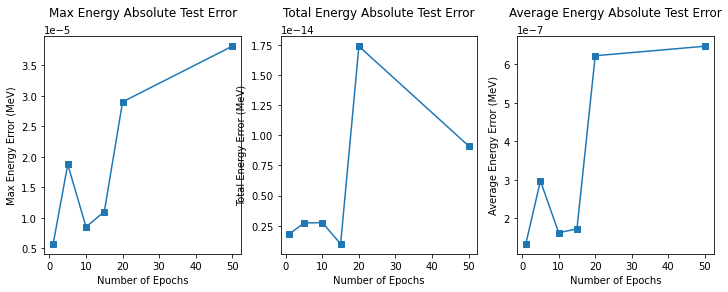

In [22]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochList, maxEnergyMSE, marker = 's')
plt.title("Max Energy Absolute Test Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Max Energy Error (MeV)')

plt.subplot(1, 3, 2)
plt.plot(epochList, totalEnergyMSE, marker = 's')
plt.title("Total Energy Absolute Test Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Total Energy Error (MeV)')

plt.subplot(1, 3, 3)
plt.plot(epochList, avgEnergyMSE, marker = 's')
plt.title("Average Energy Absolute Test Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Average Energy Error (MeV)')

Text(0, 0.5, 'Average Energy Error (MeV)')

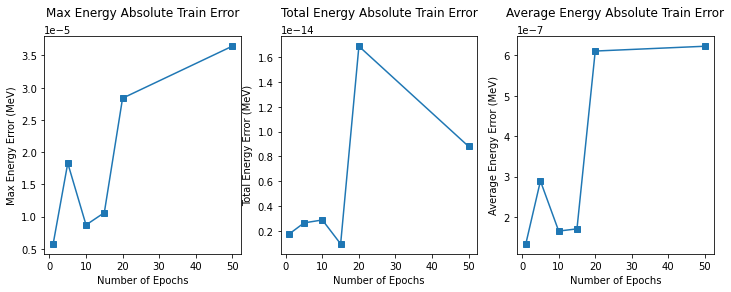

In [23]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochList, trainMaxMSE, marker='s')
plt.title("Max Energy Absolute Train Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Max Energy Error (MeV)')

plt.subplot(1, 3, 2)
plt.plot(epochList, trainTotalMSE, marker='s')
plt.title("Total Energy Absolute Train Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Total Energy Error (MeV)')

plt.subplot(1, 3, 3)
plt.plot(epochList, trainAvgMSE, marker='s')
plt.title("Average Energy Absolute Train Error", pad = 20)
plt.xlabel('Number of Epochs')
plt.ylabel('Average Energy Error (MeV)')

In [24]:
# Results with 100,000 points

# Number of epochs: 1
# Time spent: 41.4709038734436 

# Number of epochs: 5
# Time spent: 209.08989548683167 

# Number of epochs: 10
# Time spent: 423.1534082889557 

# Number of epochs: 15
# Time spent: 646.6692581176758 

# Number of epochs: 20
# Time spent: 835.7174115180969 

# Number of epochs: 50
# Time spent: 2107.0108013153076 

# Number of epochs: 1
# Max energy percent error: 19.58636320715849
# Total energy percent error: 24.325337635849067
# Average energy percent error: 14.268807343509357 

# Number of epochs: 5
# Max energy percent error: 24.806485173653556
# Total energy percent error: 43.16065515019244
# Average energy percent error: 22.830055824436172 

# Number of epochs: 10
# Max energy percent error: 22.419187074140353
# Total energy percent error: 37.010358828319994
# Average energy percent error: 19.137852256849456 

# Number of epochs: 15
# Max energy percent error: 22.667619660241414
# Total energy percent error: 37.72516050555141
# Average energy percent error: 18.710265948355165 

# Number of epochs: 20
# Max energy percent error: 34.52741609944199
# Total energy percent error: 44.01372313803574
# Average energy percent error: 33.48004556367719 

# Number of epochs: 50
# Max energy percent error: 29.11596143268651
# Total energy percent error: 41.24085503272979
# Average energy percent error: 26.759934569978807 

In [25]:
# Results with 20,000 points

# Number of epochs: 1
# Time spent: 9.709996938705444 

# Number of epochs: 5
# Time spent: 42.58600425720215 

# Number of epochs: 10
# Time spent: 86.28900504112244 

# Number of epochs: 15
# Time spent: 129.9060001373291 

# Number of epochs: 20
# Time spent: 172.23799514770508 

# Number of epochs: 50
# Time spent: 436.66264843940735 
    
# Number of epochs: 1
# Max energy percent error: 14.266001682042852
# Total energy percent error: 36.2113883322816
# Average energy percent error: 14.382154573345156 

# Number of epochs: 5
# Max energy percent error: 13.186282608741399
# Total energy percent error: 20.86685418910202
# Average energy percent error: 11.821664805706583 

# Number of epochs: 10
# Max energy percent error: 17.19713317728656
# Total energy percent error: 23.92806554969021
# Average energy percent error: 12.881195411127187 

# Number of epochs: 15
# Max energy percent error: 19.317774507765645
# Total energy percent error: 28.18222565512904
# Average energy percent error: 16.43670669838012 

# Number of epochs: 20
# Max energy percent error: 25.952888453939533
# Total energy percent error: 39.46280229124166
# Average energy percent error: 25.0593774302352 

# Number of epochs: 50
# Max energy percent error: 24.551931096353997
# Total energy percent error: 34.28238226862895
# Average energy percent error: 20.571137202898512 